In [1]:
!nvidia-smi

Mon May 16 23:10:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:23:00.0 Off |                    0 |
|  0%   24C    P8    29W / 300W |      0MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler as GradScaler
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

EPOCHS = 1
MAX_TOKEN_COUNT = 512
BATCH_SIZE = 32

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [4]:
%%time 
# train_df=pd.read_feather("./autodl-nas/major.feather")
# val_df=pd.read_feather("./autodl-nas/USPTO-2M_Validation.feather")


test_df = pd.read_feather("Test.feather")

CPU times: user 217 ms, sys: 680 ms, total: 897 ms
Wall time: 201 ms


In [7]:
LABEL_COLUMNS_3 = test_df.columns[11:-7]

In [8]:
test_df

,publication_title,sections,section_classes,section_class_subclasses,section_class_subclass_groups,cpc_sections,cpc_section_classes,cpc_section_class_subclasses,cpc_section_class_subclass_groups,abstract,...,G16Y,G06J,E99Z,relv_patents,major claim,len_k_3,major claim 1,len_k_1,major claim 5,len_k_5
0,HANGING POCKET WITH TAMPER DETECTION,B,B65,B65D,"B65D 75/14,B65D 75/52,B65D 75/56",[B],[B65],[B65D],"[B65D 75/14, B65D 2575/565, B65D 75/566, B65D ...",A hanging pocket for point-of-sale display is ...,...,0,0,0,"[0, 239, 245, 309, 401, 613, 764, 1061, 1067, ...","A hanging pocket for point-of-sale display, th...",476,"A hanging pocket for point-of-sale display, th...",134,"A hanging pocket for point-of-sale display, th...",546
1,"CRYSTALS FOR DETECTING NEUTRONS, GAMMA RAYS, A...","C,G","C07,G01,C30","C07F,G01T,C30B","C07F 5/00,G01T 1/202,G01T 3/06,C30B 15/00","[C, G]","[C07, C30, G01]","[C07F, C30B, G01T]","[C07F 5/003, C30B 15/002, G01T 3/06, G01T 1/2023]",The present disclosure discloses a method for ...,...,0,0,0,[1],"A method for growing a crystal, comprising:wei...",709,"A method for growing a crystal, comprising:wei...",369,"A method for growing a crystal, comprising:wei...",772
2,DEVICE FOR TOOTHBRUSH USAGE MONITORING,"G,A","G09,A46","G09B,A46B","G09B 19/00,A46B 15/00","[G, A]","[G09, A46]","[G09B, A46B]","[G09B 19/0084, A46B 2200/1066, A46B 15/0002]",There is provided a device for monitoring usag...,...,0,0,0,"[2, 3706]","A device for monitoring usage of a toothbrush,...",633,"A device for monitoring usage of a toothbrush,...",161,"A device for monitoring usage of a toothbrush,...",736
3,HANDHELD FLEXIBLE ROBOTIC CATHETER FOR ENDOSCO...,A,A61,A61B,"A61B 34/00,A61B 34/35,A61B 1/05,A61B 1/018,A61...",[A],[A61],[A61B],"[A61B 34/74, A61B 34/35, A61B 1/05, A61B 2034/...","A handheld, steerable catheter robotic system ...",...,0,0,0,"[3, 8, 12, 76, 85, 96, 98, 132, 136, 159, 167,...","A surgical arrangement, comprising:an endoscop...",433,"A steerable catheter robotic system, comprisin...",172,"A steerable catheter robotic system, comprisin...",550
4,Charging Terminal,G,G06,"G06K,G06F","G06K 7/00,G06F 13/42",[G],[G06],"[G06K, G06F]","[G06K 7/0013, G06F 2213/0042, G06F 13/4282]",A battery-powered device comprising a power in...,...,0,0,0,"[4, 80, 185, 193, 250, 293, 328, 410, 428, 490...",A power supply for one or more battery-powered...,472,A system comprising a battery-powered device a...,234,A system comprising a battery-powered device a...,522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,COMPOSITE YARN AND METHOD OF MAKING A CARBON N...,"C,D","C01,D01,D02","C01B,D01F,D02G","C01B 32/16,C01B 32/168,D01F 9/12,D02G 3/02","[C, B, D]","[C01, B82, D02, D01]","[C01B, B82Y, D02G, D01F]","[C01B 32/16, C01B 32/168, B82Y 30/00, D02G 3/0...",A method of making a carbon nanotube composite...,...,0,0,0,"[890, 1032, 2132, 3843, 4995]",A method of making a carbon nanotube composite...,220,A method of making a carbon nanotube composite...,65,A method of making a carbon nanotube composite...,281
4996,TECHNOLOGIES FOR CADDY ASSEMBLIES,B,"B62,B65,B25","B62B,B65D,B25H","B62B 3/00,B65D 71/52,B65D 21/02,B62B 5/06,B62B...",[B],"[B62, B65, B25]","[B62B, B65D, B25H]","[B62B 3/006, B65D 71/0003, B65D 21/0212, B25H ...",A container system including a storage base th...,...,0,0,0,[4996],A storage system comprising a first storage ba...,519,A storage system comprising a first storage ba...,239,A storage system comprising a first storage ba...,627
4997,HUMERAL AND GLENOID ARTICULAR SURFACE IMPLANT ...,A,A61,A61F,"A61F 2/40,A61F 2/30",[A],[A61],[A61F],"[A61F 2/4003, A61F 2/4081, A61F 2/30749, A61F ...",A shoulder implant system comprising a glenoid...,...,0,0,0,"[9, 25, 85, 160, 208, 263, 322, 344, 375, 520,...",A shoulder implant system comprising:a glenoid...,409,A shoulder implant system comprising:a glenoid...,194,A shoulder implant system comprising:a glenoid...,540
4998,NOISE CANCELLING SOUNDBAR DEVICE A

In [9]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512,
        test= False
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test = test
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row['major claim']
#         comment_text = "".join(data_row['claims'])

        if not self.test:
            label_3 = data_row[LABEL_COLUMNS_3]
            label_2 = data_row[LABEL_COLUMNS_2]
            label_1 = data_row[LABEL_COLUMNS_1]
            
        else:
            
            label_3 = data_row[LABEL_COLUMNS_3]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        if not self.test:
            return dict(
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            label_1=torch.FloatTensor(label_1),
            label_2=torch.FloatTensor(label_2),
            label_3=torch.FloatTensor(label_3),
                
        )
        else:
            return dict(
                comment_text=comment_text,
                input_ids = encoding["input_ids"].flatten(),
                attention_mask=encoding["attention_mask"].flatten(),
                label_3=torch.FloatTensor(label_3)
            )
        

In [70]:
class PatentDataset(Dataset):
    """
    Pass pandas dataframe, and tokeizer along with the max token length[128 default]
    
    Example: 
    -------
    train_dataset = ToxicCommentsDataset(
      train_df,
      tokenizer,
      max_token_len=MAX_TOKEN_COUNT
    )

    sample_item = train_dataset[0]
    
    """
    
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        comment_text = data_row['major claim 5']
        query = data_row.publication_title.lower()
        
        encoding = self.tokenizer.batch_encode_plus(
            [query, comment_text],
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_tensors='pt',
        )
        
        return dict(
            index = index,
            comment_text=comment_text,
            query = query,
            input_ids = encoding["input_ids"],
            attention_mask=encoding["attention_mask"]
        )


In [57]:
train_dataset = PatentDataset(
  train_df,
  tokenizer,
  max_token_len=128
)

val_dataset = PatentDataset(
  val_df,
  tokenizer,
  max_token_len=128,
  test = True
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last = True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last = True,pin_memory=True)

In [26]:
test_dataset = PatentDataset(
  test_df,
  tokenizer,
  max_token_len=512,
  test = True
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

In [11]:
Bert_model = BertModel.from_pretrained(BERT_MODEL_NAME,return_dict = True).to(device)
Tags_df = pd.read_feather("Tags.feather")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
class Tags_datasets(Dataset):
    
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 512
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
    
    def __len__(self):
        return len(self.data)
    
        
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        labels = data_row.Label
        tags = data_row.Tags
        
        encoding = self.tokenizer.encode_plus(
            tags,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            return_tensors='pt',
        )
        
        return dict(
            index=index,
            label = labels,
            input_ids=encoding['input_ids'].flatten(),
            attention_mask = encoding['attention_mask'].flatten()
        )

In [13]:
Tags_dataset = Tags_datasets(data = Tags_df,tokenizer = tokenizer, max_token_len = MAX_TOKEN_COUNT)
Tags_dataloader = DataLoader(Tags_dataset, batch_size = 1)

In [14]:
tags_embeddings = {}

for step,batch in tqdm(enumerate(Tags_dataloader),total = len(Tags_dataloader)):
    label = batch['label'][0]
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    
    with torch.no_grad():
        output = Bert_model(input_ids,attention_mask = attention_mask)
    tag_embeddings = output.pooler_output.detach().cpu()
    tags_embeddings[label] = tag_embeddings




  0%|          | 0/674 [00:00<?, ?it/s]

In [15]:
tags_embedding = np.concatenate([tags_embeddings[key] for key in LABEL_COLUMNS_3],axis = 0)
tags_embedding = torch.tensor(tags_embedding)

In [16]:
tags_embedding = tags_embedding.to(device)

In [17]:
# Contrastive learning loss funcation

class ConLoss(nn.Module):
    
    def __init__(self, temperature = 0.1):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, embeddings, label_1,label_2,label_3):
       
        # embeddings (batch_size,bert_hidden_layer) , labels (batch_size,num_classes)
        similarities = F.cosine_similarity(embeddings.unsqueeze(1),embeddings.unsqueeze(0),dim=2)/self.temperature
#         print(similarities)
        
        # mask
        logits_mask = ~torch.eye(BATCH_SIZE,dtype=torch.bool).to(device)
        labels_mask = ~torch.eye(BATCH_SIZE,dtype=torch.bool).to(device)

        exp_logits = torch.exp(similarities) * logits_mask
        loss = torch.log(exp_logits.sum(1,keepdim=True)) - similarities
        
        # labels 
        weight_1 = torch.matmul(label_1,label_1.T)
        weight_2 = torch.matmul(label_2,label_2.T)
        weight_3 = torch.matmul(label_3,label_3.T)

        weight_1 = weight_1 / torch.diag(weight_1)
        weight_1 = weight_1 * labels_mask
        weight_1 = torch.where(weight_1!=1,torch.zeros_like(weight_1).to(device),weight_1)
        weight_1 = weight_1/torch.sum(weight_1)
        
        weight_2 = weight_2 / torch.diag(weight_2)
        weight_2 = weight_2 * labels_mask
        weight_2 = torch.where(weight_2!=1,torch.zeros_like(weight_2).to(device),weight_2)
        weight_2 = weight_2/torch.sum(weight_2)
        
        weight_3 = weight_3 / torch.diag(weight_3)
        weight_3 = weight_3 * labels_mask
        weight_3 = torch.where(weight_3!=1,torch.zeros_like(weight_3).to(device),weight_3)
        weight_3 = weight_3/torch.sum(weight_3)
        
        weight = weight_1*0.2 + weight_2*0.3 + weight_3*0.5
#         print(weight)
        
        loss = weight * loss
        loss = torch.mean(loss)
        return loss
        


In [18]:
class BertNetwork(nn.Module):

    def __init__(self, n_classes: int,labels_embeddings: torch.Tensor, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCEWithLogitsLoss()
        self.Weight_1 = nn.Linear(n_classes,1)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.batch_labels_embeddings = labels_embeddings.expand(BATCH_SIZE,n_classes,self.bert.config.hidden_size)
        self.batch_labels_embeddings = self.batch_labels_embeddings.transpose(1, 2) # batch_size * 768 * 664
        self.batch_labels_embeddings.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        outputs = outputs.last_hidden_state
        
        # label-wise attention
        att = torch.bmm(outputs,self.batch_labels_embeddings)
        att = F.softmax(att,dim=1)
        joint_labels_output = torch.bmm(outputs.transpose(1,2),att)
        joint_labels_output = F.relu(self.Weight_1(joint_labels_output).squeeze(2))

        return joint_labels_output

In [19]:
class Classifier(nn.Module):
    
    def __init__(self, n_classes: int ):
        super().__init__()
        self.classifier = nn.Linear(768,n_classes)
        self.dropout = nn.Dropout(0.10)
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,embeddings,labels = None):
        
        output = self.classifier(self.dropout(embeddings))
        
        if labels is not None:
            loss = self.criterion(output,labels)
            output = (loss,output)
        
        return output

In [20]:
model = BertNetwork(len(LABEL_COLUMNS_3),tags_embedding).to(device)
Conloss =  ConLoss().to(device)
classifier = Classifier(len(LABEL_COLUMNS_3)).to(device)
# N_EPOCHS = EPOCHS

# steps_per_epoch=len(train_df) // BATCH_SIZE
# total_training_steps = steps_per_epoch * N_EPOCHS
# warmup_steps = total_training_steps // 10
# warmup_steps, total_training_steps

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# optimizer = AdamW(model.parameters(), lr=2e-4)

optimizer = AdamW([
                {'params': model.parameters()},
                {'params': classifier.parameters()}],
                lr=1e-4
)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)

/root/miniconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


NameError: name 'warmup_steps' is not defined

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

# function for evaluating the model
def evaluate(mydataloader):

    print("\nEvaluating...")
    #t0 = time.time()
    # deactivate dropout layers
    model.eval()
    classifier.eval()
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in tqdm(enumerate(mydataloader),total=len(mydataloader),desc='Eval'):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
#         label_1 = batch['label_1'].to(device)
#         label_2 = batch['label_2'].to(device)
        label_3 = batch['label_3'].to(device)
        # deactivate autograd
        with autocast():
            with torch.no_grad():
                outputs = model(input_ids, attention_mask)
#                 loss1 = Conloss(outputs,label_1=label_1,label_2=label_2,label_3=label_3)
                loss2,outputs = classifier(outputs,label_3)
#                 if step%1000 ==0:
#                     print(f"loss contrastive :{loss1}  loss classifier: {loss2}")
                outputs = torch.sigmoid(outputs)

#                 loss = loss1 +loss2
                loss = loss2
                total_loss = total_loss + loss.float().item()

                outputs = outputs.detach().float().cpu().numpy()
                labels = label_3.detach().float().cpu().numpy()
                total_preds.append(outputs)
                total_labels.append(labels)


    # compute the validation loss of the epoch
    avg_loss = total_loss / len(mydataloader)

    total_preds  = np.concatenate(total_preds, axis=0)
    total_labels = np.concatenate(total_labels, axis=0)
    model.train()
    print(f"Evaluate loss {total_loss / len(mydataloader)}")
    return avg_loss, total_preds, total_labels

In [22]:
# function to train the model
def train():
    
    now=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
    best_valid_loss = float('inf')
    model.train()
    classifier.train()
    total_loss, total_accuracy = 0, 0
    avg_loss = 0
    scaler = GradScaler()

    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),desc="Train"):
        
        if step%10000 == 0 and step!=0:
            valid_loss,_,_ = evaluate(val_dataloader)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), f"./model/Classfication_Contrastive_model{now}.pt")
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_1 = batch['label_1'].to(device)
        label_2 = batch['label_2'].to(device)
        label_3 = batch['label_3'].to(device)  
        if step > 0.8*len(train_dataloader):
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss1 = Conloss(outputs,label_1=label_1,label_2=label_2,label_3=label_3)
                loss2,_ = classifier(outputs,label_3)
                loss = loss1 + loss2

            optimizer.zero_grad()
            if step%100 == 0:
                print(f"STEP {step}: loss contrastive :{loss1}  loss classifier: {loss2}")
        else:
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss,_ = classifier(outputs,label_3)
            optimizer.zero_grad()
            if step%100 == 0:
                print(f"STEP {step}: loss classifier: {loss}")
        # add on to the total loss
        total_loss = total_loss + loss.item()
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scheduler.step()
        scaler.update()
        # model predictions are stored on GPU. So, push it to CPU
        outputs=outputs.detach().float().cpu().numpy()

        # append the model predictions
        total_preds.append(outputs)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"{step}: {avg_loss}")
  

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [61]:
train_loss, _ = train()

Train:   0%|          | 0/62484 [00:00<?, ?it/s]

STEP 0: loss classifier: 0.696835994720459
STEP 100: loss classifier: 0.6866838335990906
STEP 200: loss classifier: 0.6118441224098206
STEP 300: loss classifier: 0.48675498366355896
STEP 400: loss classifier: 0.3268370032310486
STEP 500: loss classifier: 0.17784930765628815
STEP 600: loss classifier: 0.07813026756048203
STEP 700: loss classifier: 0.03694222867488861
STEP 800: loss classifier: 0.02514052577316761
STEP 900: loss classifier: 0.016979707404971123
STEP 1000: loss classifier: 0.016611317172646523
STEP 1100: loss classifier: 0.013959872536361217
STEP 1200: loss classifier: 0.016774598509073257
STEP 1300: loss classifier: 0.014382103458046913
STEP 1400: loss classifier: 0.016049057245254517
STEP 1500: loss classifier: 0.01432554330676794
STEP 1600: loss classifier: 0.010497689247131348
STEP 1700: loss classifier: 0.010595165193080902
STEP 1800: loss classifier: 0.011892544105648994
STEP 1900: loss classifier: 0.009349433705210686
STEP 2000: loss classifier: 0.01074804738163948

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.005978638397454486
STEP 10000: loss classifier: 0.006370674353092909
STEP 10100: loss classifier: 0.006044535432010889
STEP 10200: loss classifier: 0.004869301337748766
STEP 10300: loss classifier: 0.0069182259030640125
STEP 10400: loss classifier: 0.00613055843859911
STEP 10500: loss classifier: 0.00784684531390667
STEP 10600: loss classifier: 0.0044477032497525215
STEP 10700: loss classifier: 0.004617116414010525
STEP 10800: loss classifier: 0.006067123729735613
STEP 10900: loss classifier: 0.006700961384922266
STEP 11000: loss classifier: 0.005228016991168261
STEP 11100: loss classifier: 0.006753817666321993
STEP 11200: loss classifier: 0.0034376299008727074
STEP 11300: loss classifier: 0.005387620534747839
STEP 11400: loss classifier: 0.006699678022414446
STEP 11500: loss classifier: 0.006231413222849369
STEP 11600: loss classifier: 0.006203899625688791
STEP 11700: loss classifier: 0.005159177351742983
STEP 11800: loss classifier: 0.00621421355754137
STEP 11900: los

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.005428622953959648
STEP 20000: loss classifier: 0.005561721045523882
STEP 20100: loss classifier: 0.005197197198867798
STEP 20200: loss classifier: 0.007044336758553982
STEP 20300: loss classifier: 0.003769069677218795
STEP 20400: loss classifier: 0.006686290726065636
STEP 20500: loss classifier: 0.0061054350808262825
STEP 20600: loss classifier: 0.0033906998578459024
STEP 20700: loss classifier: 0.008492987602949142
STEP 20800: loss classifier: 0.005174014717340469
STEP 20900: loss classifier: 0.004294730722904205
STEP 21000: loss classifier: 0.0052061243914067745
STEP 21100: loss classifier: 0.005837242119014263
STEP 21200: loss classifier: 0.005567563232034445
STEP 21300: loss classifier: 0.005708690732717514
STEP 21400: loss classifier: 0.005733351688832045
STEP 21500: loss classifier: 0.006456073839217424
STEP 21600: loss classifier: 0.005778762511909008
STEP 21700: loss classifier: 0.006687090266495943
STEP 21800: loss classifier: 0.005479385145008564
STEP 21900: 

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.005170335033919886
STEP 30000: loss classifier: 0.0058003924787044525
STEP 30100: loss classifier: 0.004046924877911806
STEP 30200: loss classifier: 0.0043790386989712715
STEP 30300: loss classifier: 0.0035818128380924463
STEP 30400: loss classifier: 0.004240267910063267
STEP 30500: loss classifier: 0.004001943860203028
STEP 30600: loss classifier: 0.006408420391380787
STEP 30700: loss classifier: 0.0050154561176896095
STEP 30800: loss classifier: 0.005374009255319834
STEP 30900: loss classifier: 0.005669669713824987
STEP 31000: loss classifier: 0.0058445860631763935
STEP 31100: loss classifier: 0.00479606119915843
STEP 31200: loss classifier: 0.006175150163471699
STEP 31300: loss classifier: 0.0051244087517261505
STEP 31400: loss classifier: 0.005372172221541405
STEP 31500: loss classifier: 0.004675024654716253
STEP 31600: loss classifier: 0.005710679572075605
STEP 31700: loss classifier: 0.0062867156229913235
STEP 31800: loss classifier: 0.005522147286683321
STEP 3190

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.004976469489479052
STEP 40000: loss classifier: 0.005623955745249987
STEP 40100: loss classifier: 0.005047837272286415
STEP 40200: loss classifier: 0.0053216200321912766
STEP 40300: loss classifier: 0.0049312240444123745
STEP 40400: loss classifier: 0.005876623559743166
STEP 40500: loss classifier: 0.004297416657209396
STEP 40600: loss classifier: 0.005449454765766859
STEP 40700: loss classifier: 0.006088507827371359
STEP 40800: loss classifier: 0.0048995064571499825
STEP 40900: loss classifier: 0.004243119619786739
STEP 41000: loss classifier: 0.005238858051598072
STEP 41100: loss classifier: 0.004821889102458954
STEP 41200: loss classifier: 0.0054689254611730576
STEP 41300: loss classifier: 0.004065410699695349
STEP 41400: loss classifier: 0.004671755712479353
STEP 41500: loss classifier: 0.004774031694978476
STEP 41600: loss classifier: 0.004659207072108984
STEP 41700: loss classifier: 0.005677947774529457
STEP 41800: loss classifier: 0.004407290834933519
STEP 41900:

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.004830921212988683
STEP 50000: loss contrastive :0.0024824112188071012  loss classifier: 0.0050393156707286835
STEP 50100: loss contrastive :0.002372601069509983  loss classifier: 0.004967344459146261
STEP 50200: loss contrastive :0.002595453057438135  loss classifier: 0.006768746301531792
STEP 50300: loss contrastive :0.00215713819488883  loss classifier: 0.00464751198887825
STEP 50400: loss contrastive :0.002271677367389202  loss classifier: 0.003812925424426794
STEP 50500: loss contrastive :0.0020808596163988113  loss classifier: 0.004746583290398121
STEP 50600: loss contrastive :0.0028657400980591774  loss classifier: 0.0035457215271890163
STEP 50700: loss contrastive :0.0022403262555599213  loss classifier: 0.00668055284768343
STEP 50800: loss contrastive :0.002136874245479703  loss classifier: 0.004098310600966215
STEP 50900: loss contrastive :0.0024957910645753145  loss classifier: 0.007210681680589914
STEP 51000: loss contrastive :0.0027286240365356207  loss cla

Eval:   0%|          | 0/1634 [00:00<?, ?it/s]

Evaluate loss 0.004754467493845344
STEP 60000: loss contrastive :0.002252733800560236  loss classifier: 0.005830623209476471
STEP 60100: loss contrastive :0.0020912408363074064  loss classifier: 0.003475956851616502
STEP 60200: loss contrastive :0.0021371012553572655  loss classifier: 0.0050851828418672085
STEP 60300: loss contrastive :0.0019107551779597998  loss classifier: 0.004580551292747259
STEP 60400: loss contrastive :0.0023849462158977985  loss classifier: 0.0032797595486044884
STEP 60500: loss contrastive :0.0026334747672080994  loss classifier: 0.005540740676224232
STEP 60600: loss contrastive :0.002154694637283683  loss classifier: 0.0035012983717024326
STEP 60700: loss contrastive :0.00249245367012918  loss classifier: 0.004863784182816744
STEP 60800: loss contrastive :0.0020233187824487686  loss classifier: 0.004493313375860453
STEP 60900: loss contrastive :0.002182740718126297  loss classifier: 0.0047423094511032104
STEP 61000: loss contrastive :0.002106591360643506  loss

In [51]:
model.load_state_dict(torch.load("./model/CoPatE_lr_5e-5_2022-04-30 16:25:40.pt"))

<All keys matched successfully>

In [30]:
batch = next(iter(test_dataloader))

In [31]:
input_ids = batch['input_ids']

In [34]:
input_ids.transpose(0,1).shape

torch.Size([2, 32, 512])

In [72]:
query_patent = {}
for step,batch in tqdm(enumerate(test_dataloader),total = len(test_dataloader)):
    input_ids = batch['input_ids'].transpose(0,1).to(device)
    attention_mask = batch['attention_mask'].transpose(0,1).to(device)
    with autocast():
        with torch.no_grad():
            query_cls_embedding = model.bert(input_ids[0],attention_mask[0]).last_hidden_state[:,0]
            patent_cls_embedding = model.bert(input_ids[1],attention_mask[1]).last_hidden_state[:,0]
    index = batch['index']
    for i,patent in enumerate(index):
        q = query_cls_embedding[i].detach().float().cpu()
        v = patent_cls_embedding[i].detach().float().cpu()
        query_patent[int(patent)] = (q,v)

  0%|          | 0/156 [00:00<?, ?it/s]

In [73]:
query_list = [v[0] for v in query_patent.values()]
patent_list = [v[1] for v in query_patent.values()]

query_matrix = torch.vstack(query_list)
patent_matrix = torch.vstack(patent_list)

In [74]:
# K= 5

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.3f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.3f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.3f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.241
Top@100 recall: 0.503
Top@200 precision: 0.197
Top@200 recall: 0.619
Top@500 precision: 0.130
Top@500 recall: 0.769


In [61]:
# K=3

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.3f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.3f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.3f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.240
Top@100 recall: 0.504
Top@200 precision: 0.196
Top@200 recall: 0.617
Top@500 precision: 0.130
Top@500 recall: 0.768


In [69]:
# K = 1

K0 = 100
K1 = 200
K2 = 500

precision_0 = []
recall_0 = []

precision_1 = []
recall_1 = []

precision_2 = []
recall_2 = []

# for i in tqdm(range(len(query_matrix))):
for i in tqdm(range(len(query_matrix))):    
    relv_patents = test_df['relv_patents'][i]
    similarities = F.cosine_similarity(query_matrix[i].expand_as(patent_matrix),patent_matrix)
    
    _,indices_0 = torch.topk(similarities,k=K0)
    indices_0 = indices_0.numpy()
    retrievaled = len(np.intersect1d(indices_0,relv_patents))

    precision_0.append(retrievaled/K0)
    recall_0.append(retrievaled/len(relv_patents))
    
    _,indices_1 = torch.topk(similarities,k=K1)
    indices_1 = indices_1.numpy()
    retrievaled = len(np.intersect1d(indices_1,relv_patents))
    precision_1.append(retrievaled/K1)
    recall_1.append(retrievaled/len(relv_patents))
    
    _,indices_2 = torch.topk(similarities,k=K2)
    indices_2 = indices_2.numpy()
    retrievaled = len(np.intersect1d(indices_2,relv_patents))
    precision_2.append(retrievaled/K2)
    recall_2.append(retrievaled/len(relv_patents))

print(f"Top@{K0} precision: {np.mean(precision_0):.3f}")
print(f"Top@{K0} recall: {np.mean(recall_0):.4f}")
print(f"Top@{K1} precision: {np.mean(precision_1):.3f}")
print(f"Top@{K1} recall: {np.mean(recall_1):.4f}")
print(f"Top@{K2} precision: {np.mean(precision_2):.3f}")
print(f"Top@{K2} recall: {np.mean(recall_2):.4f}")

  0%|          | 0/4992 [00:00<?, ?it/s]

Top@100 precision: 0.235
Top@100 recall: 0.4927
Top@200 precision: 0.193
Top@200 recall: 0.6064
Top@500 precision: 0.128
Top@500 recall: 0.7597


In [46]:
# compute the MAP

K = 100

precision = []
recall= []


def precision(results,ground_truths,k:int):

    relevances = [1 if d in ground_truths else 0 for d in results[:k]]
    return sum(relevances)/ k 

def average_precison(patent_id:int,k:int):
    
    P_k = []
    similarities = F.cosine_similarity(query_matrix[patent_id].expand_as(patent_matrix),patent_matrix)
    _,results = torch.topk(similarities,k=K)
    ground_truths = test_df['relv_patents'][patent_id]
    results = results.tolist()

    for i,index in enumerate(results):
        if index in ground_truths:
            p_k = precision(results,ground_truths,i+1)
        else:
            p_k = 0
            
        P_k.append(p_k)
     
    return sum(P_k)/min(len(ground_truths),K)
        
                       
    
def mean_average_precision(K=K):
    aps = []
    for patent_id in tqdm(range(query_matrix.shape[0])):
        ap = average_precison(patent_id,K)
        aps.append(ap)

    print(mean(aps))
            
            
mean_average_precision(K)

  0%|          | 0/4992 [00:00<?, ?it/s]

0.3677164846379532


In [47]:
from statistics import mean

In [48]:
# reciprocal_rank

def reciprocal_rank(patent_id:int,k:int):
    
    similarities = F.cosine_similarity(query_matrix[patent_id].expand_as(patent_matrix),patent_matrix)
    _,results = torch.topk(similarities,k=K)
    ground_truths = test_df['relv_patents'][patent_id]
    results = results.tolist()
    
    r_r = 0
    for i,index in enumerate(results):
        if index in ground_truths:
            r_r = 1/(i+1)
            break
            
    return r_r

def mean_reciprocal_rank(K=K):
    arr = []
    for patent_id in tqdm(range(query_matrix.shape[0])):
        ap = reciprocal_rank(patent_id,K)
        arr.append(ap)

    print(mean(arr))
    
mean_reciprocal_rank(100)

  0%|          | 0/4992 [00:00<?, ?it/s]

0.7067015726386224


## Training

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)


true = np.array(total_labels)
pred = np.array(total_preds>0.5)

dic = {
    "Accuracy" : accuracy_score(true,pred),
    "Precision-micro" : precision_score(true,pred,average='micro'),
    "Precision-macro" : precision_score(true,pred,average='macro'),
    "recall-micro" : recall_score(true,pred,average='micro'),
    "recall-macro" : recall_score(true,pred,average='macro'),
    "f1_micro" : f1_score(true,pred,average='micro'),
    "f1-macro" : f1_score(true,pred,average='macro')
}

/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [65]:
dic

{'Accuracy': 0.390224358974359,
 'Precision-micro': 0.8120604781997187,
 'Precision-macro': 0.42710094868809545,
 'recall-micro': 0.5027209403569873,
 'recall-macro': 0.2537291381739999,
 'f1_micro': 0.6210002688894863,
 'f1-macro': 0.30122267995095137}

In [29]:
dic

{'Accuracy': 0.41185897435897434,
 'Precision-micro': 0.8182578164186591,
 'Precision-macro': 0.43324047869837756,
 'recall-micro': 0.5326512842838484,
 'recall-macro': 0.276700314323264,
 'f1_micro': 0.6452633660755488,
 'f1-macro': 0.32074197267429944}

In [34]:
total_preds = torch.tensor(total_preds)

In [36]:
total_preds

tensor([[3.9983e-04, 2.9981e-05, 2.0027e-04,  ..., 1.1921e-07, 1.1921e-07,
         0.0000e+00],
        [1.6987e-05, 1.4901e-06, 4.1723e-07,  ..., 9.5367e-07, 7.1526e-07,
         7.7486e-07],
        [6.7186e-04, 5.8174e-04, 1.7262e-04,  ..., 1.3292e-05, 1.5497e-06,
         1.6689e-06],
        ...,
        [2.4438e-06, 2.1458e-06, 6.5565e-07,  ..., 5.7399e-05, 1.9670e-06,
         1.7881e-06],
        [2.9206e-06, 8.8215e-06, 7.1526e-07,  ..., 1.6868e-04, 5.3644e-07,
         2.3842e-07],
        [5.5420e-01, 4.0210e-01, 6.7177e-03,  ..., 2.3842e-07, 4.1723e-07,
         1.1921e-07]])

In [42]:
total_labels = torch.tensor(total_labels)

In [44]:
labels = torch.argmax(total_labels,dim=1,keepdim=True)

In [45]:
preds = torch.argmax(total_preds,dim=1,keepdim=True)

In [60]:
labels[i]

tensor([148])

In [73]:
tp = 0
fp = 0
total = total_labels.shape[0]
ls = []

for i in range(total_labels.shape[0]):
    label = torch.where(total_labels[i])
    pr = 1
    for l in label[0]:
        if l == preds[i]:
            tp += 1
            break
    else:
        pr = 0
    ls.append(pr/label[0].shape[0])
    
precision = tp/total
recall = np.mean(ls)
f1_score = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1_score)

0.8303285256410257
0.5720018696581196
0.6773717102463864


In [ ]:
for total_labels in 

In [48]:
labels == preds

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [ True]])

In [50]:
precision_score(labels,preds,average='micro')

0.602363782051282

In [ ]:
def evalTop1(model, loader):
    model.eval()
    
    correct = 0
    total = len(loader.dataset)

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += torch.eq(pred, y).sum().float().item()
    return correct / total


## batch_size = 8时的模型测试

In [66]:
model.load_state_dict(torch.load("./model/Classfication_Contrastive_model2022-04-29 16:49:42.pt"))

<All keys matched successfully>

In [23]:
model.load_state_dict(torch.load("./model/CoPatE_final.pt"))

<All keys matched successfully>

In [24]:
classifier.load_state_dict(torch.load("./model/CoPatE_classifier_final.pt"))

<All keys matched successfully>

In [67]:
test_df = pd.read_feather("2021-sample-5000_retrieval_two.feather")

In [68]:
test_dataset = PatentDataset(
  test_df,
  tokenizer,
  max_token_len=128,
  test = True
)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

avg_loss, total_preds, total_labels = evaluate(test_dataloader)


Evaluating...


Eval:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluate loss 0.005460061910502517


In [27]:
avg_loss, total_preds, total_labels = evaluate(test_dataloader)


Evaluating...


Eval:   0%|          | 0/156 [00:00<?, ?it/s]

Evaluate loss 0.005001947419562687


In [76]:
data = patent_matrix.numpy()

In [77]:
data

array([[-0.01514346,  0.5677625 , -0.07924097, ..., -0.47089866,
        -0.22311102, -0.12973738],
       [-0.11729708, -0.15167144, -0.66343474, ...,  0.7703791 ,
         0.3370954 ,  0.40730044],
       [ 0.07710651,  0.69955975,  0.23274456, ..., -0.35187572,
        -0.8279639 , -0.17830679],
       ...,
       [-0.9070438 ,  1.4368451 , -0.7047645 , ..., -0.9063978 ,
         0.50868225, -0.68990016],
       [-0.38762587,  0.36194578,  0.42073044, ..., -0.55101323,
         0.27085465,  0.03920824],
       [-0.2689549 ,  0.6793076 ,  0.034377  , ..., -0.48134428,
        -1.2723379 , -0.5952577 ]], dtype=float32)

In [80]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris,load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

digits = load_digits()
X_tsne = TSNE(n_components=2).fit_transform(data)

X_pca = PCA(n_components=2).fit_transform(data)

ckpt_dir="images"
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)





/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [194]:
label1 = {}

def addlabel1(x):
    for i in x:
        if i in label1:
            label1[i] +=1
        else:
            label1[i] = 1
        
test_df.cpc_sections.apply(addlabel1)

0       None
1       None
2       None
3       None
4       None
        ... 
4995    None
4996    None
4997    None
4998    None
4999    None
Name: cpc_sections, Length: 5000, dtype: object

In [127]:
label = test_df.cpc_sections.value_counts()

In [149]:
label = test_df.cpc_sections.apply(len)

In [161]:
paten = label[label==1].index

In [163]:
df = test_df.iloc[paten]

In [168]:
paten

Int64Index([   0,    3,    4,    5,    7,    9,   11,   12,   13,   14,
            ...
            4989, 4990, 4991, 4992, 4993, 4994, 4996, 4997, 4998, 4999],
           dtype='int64', length=3381)

In [171]:
data = data[paten[:-8]]

In [164]:
df

,publication_title,sections,section_classes,section_class_subclasses,section_class_subclass_groups,cpc_sections,cpc_section_classes,cpc_section_class_subclasses,cpc_section_class_subclass_groups,abstract,...,G16Y,G06J,E99Z,relv_patents,major claim,len_k_3,major claim 1,len_k_1,major claim 5,len_k_5
0,HANGING POCKET WITH TAMPER DETECTION,B,B65,B65D,"B65D 75/14,B65D 75/52,B65D 75/56",[B],[B65],[B65D],"[B65D 75/14, B65D 2575/565, B65D 75/566, B65D ...",A hanging pocket for point-of-sale display is ...,...,0,0,0,"[0, 239, 245, 309, 401, 613, 764, 1061, 1067, ...","A hanging pocket for point-of-sale display, th...",476,"A hanging pocket for point-of-sale display, th...",134,"A hanging pocket for point-of-sale display, th...",546
3,HANDHELD FLEXIBLE ROBOTIC CATHETER FOR ENDOSCO...,A,A61,A61B,"A61B 34/00,A61B 34/35,A61B 1/05,A61B 1/018,A61...",[A],[A61],[A61B],"[A61B 34/74, A61B 34/35, A61B 1/05, A61B 2034/...","A handheld, steerable catheter robotic system ...",...,0,0,0,"[3, 8, 12, 76, 85, 96, 98, 132, 136, 159, 167,...","A surgical arrangement, comprising:an endoscop...",433,"A steerable catheter robotic system, comprisin...",172,"A steerable catheter robotic system, comprisin...",550
4,Charging Terminal,G,G06,"G06K,G06F","G06K 7/00,G06F 13/42",[G],[G06],"[G06K, G06F]","[G06K 7/0013, G06F 2213/0042, G06F 13/4282]",A battery-powered device comprising a power in...,...,0,0,0,"[4, 80, 185, 193, 250, 293, 328, 410, 428, 490...",A power supply for one or more battery-powered...,472,A system comprising a battery-powered device a...,234,A system comprising a battery-powered device a...,522
5,Transmittance-Variable Device,G,G02,G02F,"G02F 1/139,G02F 1/13363,G02F 1/1335,G02F 1/1337",[G],[G02],[G02F],"[G02F 1/1396, G02F 1/133636, G02F 2202/40, G02...",A transmittance-variable device is disclosed h...,...,0,0,0,"[5, 68, 145, 166, 178, 198, 294, 359, 363, 458...","A transmittance-variable device, comprising:a ...",383,"A transmittance-variable device, comprising:a ...",274,"A transmittance-variable device, comprising:a ...",495
7,MULTILAYER SUBSTRATE,H,H05,H05K,H05K 1/02,[H],"[H05, H01]","[H05K, H01P]","[H05K 1/0298, H01P 3/00, H05K 1/0284]",A multilayer substrate includes an insulator t...,...,0,0,0,"[7, 3716, 4844]",A multilayer substrate comprising:an insulator...,308,A multilayer substrate comprising:an insulator...,123,A multilayer substrate comprising:an insulator...,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,Grain Bin Unloading Conveyor System,B,B65,B65G,"B65G 65/42,B65G 21/08,B65G 21/02",[B],[B65],[B65G],"[B65G 65/42, B65G 2201/042, B65G 21/02, B65G 2...",An unloading conveyor system for unloading gra...,...,0,0,0,"[679, 995, 1378, 1779, 1884, 2487, 2521, 2557,...",An unloading conveyor system for a grain bin c...,171,An unloading conveyor system for a grain bin c...,61,An unloading conveyor system for a grain bin c...,229
4996,TECHNOLOGIES FOR CADDY ASSEMBLIES,B,"B62,B65,B25","B62B,B65D,B25H","B62B 3/00,B65D 71/52,B65D 21/02,B62B 5/06,B62B...",[B],"[B62, B65, B25]","[B62B, B65D, B25H]","[B62B 3/006, B65D 71/0003, B65D 21/0212, B25H ...",A container system including a storage base th...,...,0,0,0,[4996],A storage system comprising a first storage ba...,519,A storage system comprising a first storage ba...,239,A storage system comprising a first storage ba...,627
4997,HUMERAL AND GLENOID ARTICULAR SURFACE IMPLANT ...,A,A61,A61F,"A61F 2/40,A61F 2/30",[A],[A61],[A61F],"[A61F 2/4003, A61F 2/4081, A61F 2/30749, A61F ...",A shoulder implant system comprising a glenoid...,...,0,0,0,"[9, 25, 85, 160, 208, 263, 322, 344, 375, 520,...",A shoulder implant system comprising:a glenoid...,409,A shoulder implant system comprising:a glenoid...,194,A shoulder implant system comprising:a glenoid...,540
4998,NOISE CANCELLING SOUNDBAR DEVICE AND SYSTEM,H,H04,H04R,H04R 3/02,[H],[H04],[H04R],[H04R 3/02],A noise cancelling soundbar that may be integr...,...,0,0,0,"[50, 80, 172, 379, 535, 633, 657, 660, 6

In [129]:
label[:15]

[G]          1004
[H]           982
[A]           594
[B]           362
[F]           170
[C]           162
[E]            95
[D]            12
[B, C]          1
[B, E]          1
[F, B, C]       1
[G, B]          1
[F, A, B]       1
[G, A]          1
[G, A]          1
Name: cpc_sections, dtype: int64

In [195]:
label1 = sorted(label1.items(),key=lambda x: x[1])

In [196]:
label1

[('D', 30),
 ('Y', 36),
 ('E', 195),
 ('F', 377),
 ('C', 503),
 ('B', 907),
 ('A', 1015),
 ('H', 1776),
 ('G', 1980)]

In [197]:
label1 = [x[0] for x in label1]

In [198]:
label1

['D', 'Y', 'E', 'F', 'C', 'B', 'A', 'H', 'G']

In [199]:
def find_class(x):
    for k,i in enumerate(label1):
        if x == i:
            return k
    return -1

targets = df[:-8].cpc_sections.apply(find_class)
            

In [200]:
targets.value_counts()

8    1004
7     980
6     591
5     360
3     170
4     161
2      95
0      12
Name: cpc_sections, dtype: int64

In [201]:
targets = targets.to_list()

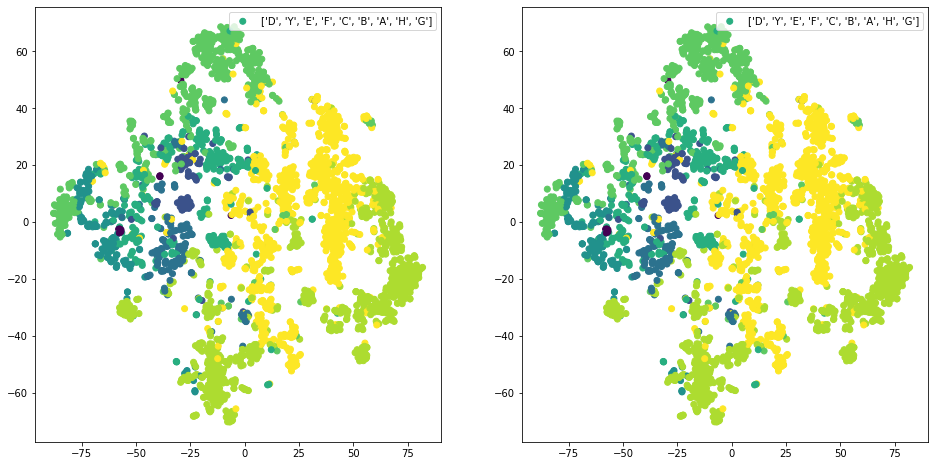

In [245]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(tsne[:, 0], tsne[:, 1],c=targets,label=label1)
plt.legend()
plt.subplot(122)
plt.scatter(tsne[:, 0], tsne[:, 1],c=targets,label=label1)
plt.legend()
plt.savefig("t-sne.png",dpi=200)

In [241]:
tsne = TSNE(n_components=2, learning_rate=1000, metric='cosine',random_state=42,
            n_jobs=-1).fit_transform(data)

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [236]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=200, metric='cosine',n_jobs=-1)
tsne.fit_transform(data)
outs_2d = np.array(tsne.embedding_)




/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Text(0.5, 1.0, 'feats dimensionality reduction visualization by tSNE,test data')

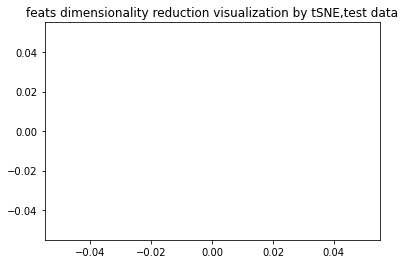

In [239]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
css4 = list(mcolors.CSS4_COLORS.keys())
#我选择了一些较清楚的颜色，更多的类时也能画清晰
color_ind = [2,7,9,10,11,13,14,16,17,19,20,21,25,28,30,31,32,37,38,40,47,51,
         55,60,65,82,85,88,106,110,115,118,120,125,131,135,139,142,146,147]
css4 = [css4[v] for v in color_ind]
for lbi in range(10):
    temp = outs_2d[label1==lbi]
    plt.plot(temp[:,0],temp[:,1],'.',color=css4[lbi])
plt.title('feats dimensionality reduction visualization by tSNE,test data')
